In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [2]:
from concreteproperties.material import Concrete, SteelBar
from concreteproperties.stress_strain_profile import (
ConcreteLinear,
RectangularStressBlock,
SteelElasticPlastic,
)
from sectionproperties.pre.library.concrete_sections import concrete_rectangular_section
from sectionproperties.pre.geometry import Geometry
from sectionproperties.pre.library.primitive_sections import *
from concreteproperties.pre import add_bar_rectangular_array, add_bar
from sectionproperties.analysis.section import Section
from concreteproperties.analysis_section import AnalysisSection
from concreteproperties.concrete_section import ConcreteSection

from concreteproperties.results import MomentInteractionResults, MomentCurvatureResults

from concreteproperties import EurocodeNonLinear 

Using PARDISO solver


In [3]:
class PotNosnik:
    def __init__(self, delka):
        if (delka<1750):
            raise ValueError(f"Zadana hodnota {delka:.0f} mm je mensi nez minimalni delka nosniku 1750 mm!")
        if (delka>8250):
            raise ValueError(f"Zadana hodnota {delka:.0f} mm je vetsi nez minimalni delka nosniku 8250 mm!")
        if (delka % 250 != 0.):
            raise ValueError("Nosnik neni v modulu 250 mm!")
        self.delka = delka
        self.ds_horni = 8
        self.ucinnost_svaru_diagonaly = 0.6
        self.oznaceni = f"POT {int(self.delka/10)}/902"
        if (self.delka <= 6250):
            self.vyska_tramecku = 175
            self.dw_diag = 5
        else:
            self.vyska_tramecku = 230
            self.dw_diag = 6
        # prumer krajni vyztuze
        if (self.delka <= 2750):
            self.ds_krajni = 8
        elif (self.delka <= 3750):
            self.ds_krajni = 10
        else:
            self.ds_krajni = 12
        #prumer stredni vyztuze
        if (self.delka <= 4250):
            self.ds_stredni = 0
        elif (self.delka == 4500):
            self.ds_stredni = 6
        elif (self.delka == 4750):
            self.ds_stredni = 8
        elif (self.delka == 5000):
            self.ds_stredni = 10
        elif (self.delka <= 5750):
            self.ds_stredni = 12
        elif (self.delka <= 6500):
            self.ds_stredni = 14
        elif (self.delka == 6750):
            self.ds_stredni = 16
        elif (self.delka <= 7500):
            self.ds_stredni = 18
        else:
            self.ds_stredni = 20

In [4]:
#============================== DEFINICE FUNKCI ==============================
def vlozka_miako_geom(ovn, vys_vlozky):
    """
    Geometrie vlozky pomoci knihovny sectionproperties
    """
    b_vlozka = ovn-100
    if vys_vlozky == 80:
        rec = rectangular_section(d=vys_vlozky, b=b_vlozka/2, material=None)
        rec1 = rectangular_section(d=60, b=30, material=None).align_to(other=rec, on="bottom", inner=True).align_to(other=rec, on="left", inner=True)
        pulka_vlozky = (rec - rec1)
    elif vys_vlozky == 250:
        rec = rectangular_section(d=vys_vlozky, b=b_vlozka/2, material=None)
        rec1 = rectangular_section(d=60, b=35, material=None).align_to(other=rec, on="bottom", inner=True).align_to(other=rec, on="left", inner=True)
        rec2 = rectangular_section(d=16, b=84, material=None).align_to(other=rec, on="top", inner=True).align_to(other=rec, on="left", inner=True)
        rec3 = rectangular_section(d=26, b=99, material=None).align_to(other=rec2, on="bottom", inner=False).align_to(other=rec, on="left", inner=True)
        tri = triangular_section(b=99,h=-33).align_to(other=rec3, on="bottom", inner=False).align_to(other=rec, on="left", inner=True)
        pulka_vlozky = (rec - rec1 - rec2 - rec3 - tri)
    elif vys_vlozky in [150, 190, 230]:
        rec = rectangular_section(d=vys_vlozky, b=b_vlozka/2, material=None)
        rec1 = rectangular_section(d=60, b=35, material=None).align_to(other=rec, on="bottom", inner=True).align_to(other=rec, on="left", inner=True)
        tri = triangular_section(b=15,h=-40).align_to(other=rec, on="top", inner=True).align_to(other=rec, on="left", inner=True).shift_section(0,-12)
        pulka_vlozky = (rec - rec1 - tri)
    return pulka_vlozky

def pot_nosnik_geom(pot_nosnik):
    """
    Geometrie POT nosniku + vyztuzeni pomoci knihovny sectionproperties a concreteproperties
    """
    #geometry
    rec = rectangular_section(d=45, b=130, material=C25)
    tri1 = triangular_section(b=5.5,h=-5.5, material=C25).rotate_section(-135).align_to(other=rec, on="top", inner=True).align_to(other=rec, on="left", inner=True)
    tri2 = tri1.mirror_section(axis="y").align_to(other=rec, on="top", inner=True).align_to(other=rec, on="right", inner=True)
    pot = rec - tri1 - tri2
    #rebar
    pot = add_bar_rectangular_array(geometry=pot, area=pi*pot_nosnik.ds_krajni**2/4, material=B500B, n_x=2, x_s=130-30-pot_nosnik.ds_krajni, n_y=1, y_s=420,anchor=(15+pot_nosnik.ds_krajni/2, 15+pot_nosnik.ds_krajni/2))
    if pot_nosnik.ds_stredni != 0:
        pot = add_bar(geometry=pot, area=pi*pot_nosnik.ds_stredni**2/4, material=B500B, x=130/2, y=15+pot_nosnik.ds_stredni/2)
    y_horni = 15 - pot_nosnik.ds_horni / 2
    y_horni += 175 if pot_nosnik.delka <= 6250. else 230
    pot = add_bar(geometry=pot, area=pi*pot_nosnik.ds_horni**2/4, material=B500B, x=130/2, y=y_horni)
    return pot

def miako_prurez_ULS(pot_nosnik, pocet_pot, vyska_vlozky, sirky_vlozek, tloustka_stropu, beton, kari_prumer, kari_vzdalenost):
    """
    Definice prurezu stropu v MSU pomoci knihovny sectionproperties a concreteproperties
    """
    b_eff = (sirky_vlozek[0]+sirky_vlozek[1])/2 + (pocet_pot-1)*160
    rec = rectangular_section(d=tloustka_stropu, b=b_eff, material=beton)
    vlozka_left = vlozka_miako_geom(sirky_vlozek[0], vyska_vlozky).mirror_section(axis="y").align_to(other=rec, on="bottom", inner=True).align_to(other=rec, on="left", inner=True)
    vlozka_right = vlozka_miako_geom(sirky_vlozek[1], vyska_vlozky).align_to(other=rec, on="bottom", inner=True).align_to(other=rec, on="right", inner=True)
    rec2 = rectangular_section(d=60, b=b_eff, material=None)
    
    n_x = int(floor(b_eff / kari_vzdalenost))
    anchor = (
        (b_eff - (n_x-1) * kari_vzdalenost) / 2,
        (tloustka_stropu - 20 - kari_prumer / 2)
    )
    rec = add_bar_rectangular_array(geometry=rec, area=pi*kari_prumer**2/4, material=B500B, n_x=n_x, x_s=kari_vzdalenost, n_y=1, y_s=69, anchor=anchor)
    
    geom = rec - vlozka_left - vlozka_right - rec2
    pot = pot_nosnik_geom(pot_nosnik).align_to(other=geom, on="bottom", inner=True).shift_section(y_offset=-45)
    for n in range(pocet_pot):
        geom = geom + pot.shift_section(sirky_vlozek[0]/2-130/2+n*160)
    conc_sec = ConcreteSection(geom)
    
    return conc_sec

In [5]:
#============================== VSTUPY ==============================
F_CK = [20, 25, 30, 35]
OVN = [(500,500), (500,625), (625,625)]
POCET_POT = [1,2]
TL_STROPU = [210, 250, 250, 290]
VYS_VLOZKY = [150, 190, 250, 230]
# L = np.arange(4500,8500,250)

# F_CK = [20]
# OVN = [(625,625)]
# POCET_POT = [1]
# TL_STROPU = [290]
# VYS_VLOZKY = [230]
# L = np.arange(4500,-3500+8500,250)

#============================== DEFINICE MATERIALU ==============================
B500B = SteelBar(
    name="BSt 500 M",
    density=7.85e-6,
    stress_strain_profile=SteelElasticPlastic(
        yield_strength=500/1.15,
        elastic_modulus=200e3,
        fracture_strain=0.1,
    ),
    colour="red",
)

conc_mat = EurocodeNonLinear(
    elastic_modulus=35e3,
    ultimate_strain=0.0035,
    compressive_strength=40,
    compressive_strain=0.0023,
    tensile_strength=3.5,
    tension_softening_stiffness=7e3,
)

C25 = Concrete(name="C25/30",
               density=2.4e-6,
               stress_strain_profile=conc_mat,
               ultimate_stress_strain_profile=RectangularStressBlock(
               compressive_strength=25,
               alpha=2/3,
               gamma=0.8,
               ultimate_strain=0.0035,
               ),
               flexural_tensile_strength=3.4,
               colour="darkgrey",
               )

C20 = Concrete(name="C20/25",
               density=2.4e-6,
               stress_strain_profile=conc_mat,
               ultimate_stress_strain_profile=RectangularStressBlock(
               compressive_strength=25,
               alpha=2/3,
               gamma=0.8,
               ultimate_strain=0.0035,
               ),
               flexural_tensile_strength=3.4,
               colour="grey",
               )

In [6]:
pot = PotNosnik(delka=4000)
pot

/home/daniel/repos/master-thesis/.venv/lib/python3.11/site-packages/concreteproperties/concrete_section.py:61: UserWarning: The provided geometry contains overlapping regions, results may be incorrect.
  warnings.warn(msg)


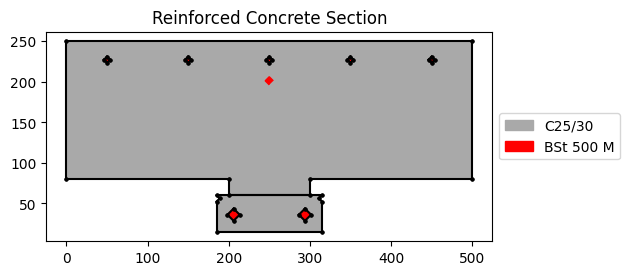

<Axes: title={'center': 'Reinforced Concrete Section'}>

In [7]:
concrete_section = miako_prurez_ULS(
    pot_nosnik=pot,
    pocet_pot=1,
    vyska_vlozky=80,
    sirky_vlozek=(500, 500),
    tloustka_stropu=250,
    beton=C25,
    kari_prumer=6,
    kari_vzdalenost=100,
)

concrete_section.plot_section()

In [8]:
mi_res_pos = concrete_section.moment_interaction_diagram(progress_bar=True)
mi_res_neg = concrete_section.moment_interaction_diagram(theta=np.pi, progress_bar=True)

Output()

Output()

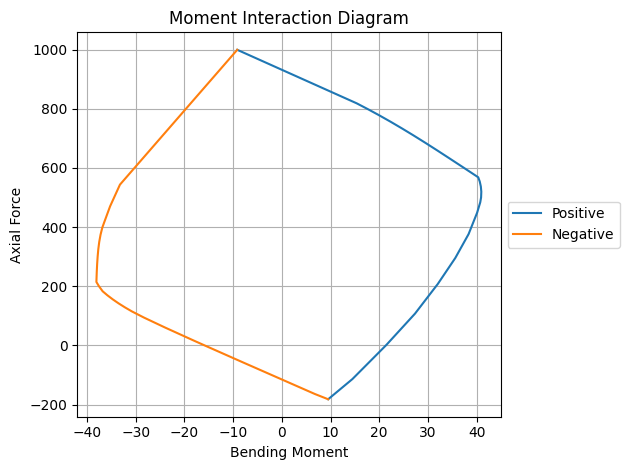

<Axes: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [9]:
MomentInteractionResults.plot_multiple_diagrams(
    moment_interaction_results=[mi_res_pos, mi_res_neg],
    labels=["Positive", "Negative"],
    fmt="-",
)

In [ ]:
mk_res_pos = concrete_section.moment_curvature_analysis()
mk_res_neg = concrete_section.moment_curvature_analysis(theta=np.pi)

Output()

Output()

In [ ]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=[mk_res_pos],# mk_res_neg], 
    labels=['+'], 
    fmt="x-"
)